<a href="https://colab.research.google.com/github/charlielutra/CIFAR-10-image-classification/blob/main/CPU_CIFAR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm

In [ ]:
# !pip install bayesian_optimization

# Could not get this to work in a timely manner

In [ ]:
# Setup - partially copy-pasted from 06, then edited

# Python ≥3.9 is required
import sys
assert sys.version_info >= (3, 9)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Other random libraries I'm using
import bayes_opt
#import umap

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

# Statistical analysis and testing
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Ignore useless warnings (see SciPy issue #5998 and seaborn/matplotlib bug)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", message="The figure layout has changed to tight")

In [ ]:
# For the port from VSCode to Colab:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/My Drive/

Mounted at /content/drive
/content/drive/My Drive


# Presentation of the problem

The CIFAR-10 dataset is a dataset of 60,000 colour images with 32x32 pixels each. Each pixel contains 3 integers in the range 0-255 (RGB), so the data needs to be scaled before it is used to train models. Each image belongs to one of 10 mutually exclusive categories. The task is to assign images to a category. Hence this is a supervised, multiclass classification problem.

This dataset is known for being significantly harder than MNIST - the most successful CIFAR-10 models yet created still all have 10-20% error at least.

The dataset is popular enough to be built-in to many packages, including pytorch; however, I wanted the extra challenge of preprocessing the data myself.

# Data extraction

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
# Extracting training data

extracted_data = []
extracted_labels = []
for batch in range(1,6):
    extracted_data.append(unpickle(f"cifar-10-batches-py/data_batch_{batch}")[b"data"])
    extracted_labels.append(unpickle(f"cifar-10-batches-py/data_batch_{batch}")[b"labels"])

X_train = np.vstack(extracted_data) # Shape = (50000, 3072)
y_train = np.hstack(extracted_labels) # Shape = (50000,)

In [ ]:
# Extracting test data
X_test = unpickle("cifar-10-batches-py/test_batch")[b"data"] # Shape = (10000, 3072)
y_test = np.array(unpickle("cifar-10-batches-py/test_batch")[b"labels"]) # Shape = (10000,)

In [ ]:
label_names = unpickle("cifar-10-batches-py/batches.meta")[b"label_names"]
label_names

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

# Data presentation

In [ ]:
# Function to reshape one image from shape [3072,] to shape [size, size, 3]

def reshape_image (pixels_1d, size):
  # pixels_1d should be shape (3072,) for this dataset
  # size should be 32 for this dataset
  # Output shape is (size, size, 3)
  reshaped = pixels_1d.reshape(3,size,size)
  transposed = np.transpose(reshaped,axes=(1,2,0))
  return transposed
  # To plot: plt.imshow(transposed)

In [ ]:
def plot_image(pixels_1d):
  plt.imshow(reshape_image(pixels_1d,32))

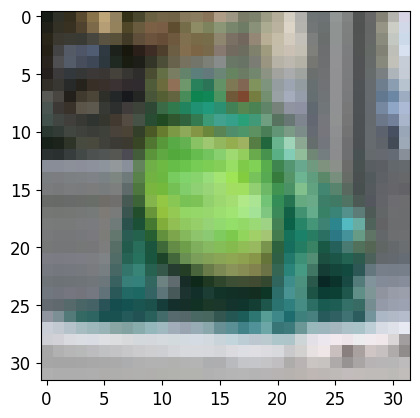

In [ ]:
plot_image(X_train[19]) # Example image from the dataset (chosen because it's a cute frog!)

# Data preprocessing

In [ ]:
# This data needs scaling!
# It's all integers from 0-255 -> minmax scaling required

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,1))
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

In [ ]:
# Define function for visualising confusion matrix

def plot_conf_matrix(c_mat_cv, model_name):
    plt.matshow(c_mat_cv, cmap="jet")
    ax = plt.gca()
    ax.set_title("CIFAR-10 classification model: "+model_name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(-1,10))
    ax.set_yticks(np.arange(-1,10))
    ax.set_xticklabels([""]+label_names, rotation="vertical")
    ax.set_yticklabels([""]+label_names)
    for i in range(0, 10):
        for j in range(0, 10):
            c = c_mat_cv[j, i]
            ax.text(i, j, str(c), va='center', ha='center')

    plt.show()

# Models to train:
### Random Forest
### LightGBM
### Convolutional neural network (CNN)

(SVM and other linear models are known to be rather ineffective at classifying images)

In [ ]:
# PCA before doing the random forest seems like a good idea to speed up the process.
# PCA on very high dimensionality data like this takes a very long time, so to speed it up use randomized PCA (parameter inside PCA).

#from sklearn.decomposition import PCA
#pca = PCA(
#    svd_solver="randomized",
#    random_state=24
#)
#pca = pca.fit(X_train_)
#cumsum = cumsum = np.cumsum(pca.explained_variance_ratio_)
#n_dims = np.argmax(cumsum >= 0.95) + 1
#n_dims

# Wow, went from 30m to 5m when randomisation used!

In [ ]:
#X_train_reduced = pca.transform(X_train_)
#X_test_reduced = pca.transform(X_test_)

In [ ]:
# Random forest
# Do hyperparameter tuning on this one!

from sklearn.ensemble import RandomForestClassifier
forest_cl = RandomForestClassifier(
   n_estimators=100,
   criterion="log_loss",
   max_depth=None,
   n_jobs=-1,
   random_state=24
)
forest_cl.fit(X_train_, y_train)

# Took 7m pre-PCA

# Took 4m30 post-PCA

# ...Note to self: works much much faster at some times than others!!
# I think it's to do with amount of laptop charge, and maybe laptop heat levels
# Took 1m11 at 68% just now

RandomForestClassifier(criterion='log_loss', n_jobs=-1, random_state=24)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_rf = forest_cl.predict(X_test_)

acc = accuracy_score(y_test, y_pred_rf)
print(acc)

# With no hyperparameter tuning, random forest can reach an accuracy of 46.41%.
# Not entirely useless!! (Random guessing would be 10%)
# Next, do hyperparameter tuning, try to make it better

# Post-PCA: only 29.4% accuracy pre-tuning :(
# But hopefully now hyperparameter tuning will be somewhat viable?
# (... It was not)


0.4641


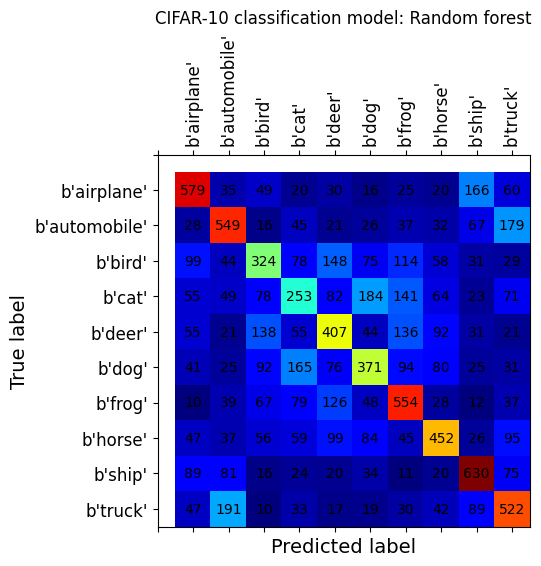

In [ ]:
# Model evaluation
from sklearn.metrics import confusion_matrix

plot_conf_matrix(confusion_matrix(y_test, y_pred_rf), "Random forest")

In [ ]:
# Achieved 46.41% accuracy with default hyperparameters

# LightGBM


In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    random_state=24,
    n_jobs=-1
)

In [ ]:
lgbm_clf.fit(X_train_, y_train)

# Finished in just under 10mins at low battery
# Finished in 3m50 at 63%

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 10.381467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751260
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 3072
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585


LGBMClassifier(n_jobs=-1, random_state=24)

In [ ]:
#from sklearn.metrics import accuracy_score

y_pred_lgbm = lgbm_clf.predict(X_test_)

acc = accuracy_score(y_test, y_pred_lgbm)
print(acc)

0.5311


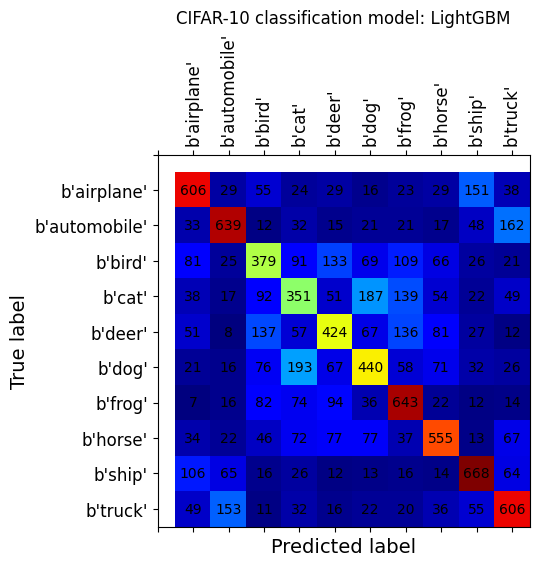

In [ ]:
from sklearn.metrics import confusion_matrix

plot_conf_matrix(confusion_matrix(y_test, y_pred_lgbm), "LightGBM")

This is the model to beat so far!
With all default parameters and random_state=24, achieved accuracy of 53.11%

# Hyperparameter tuning of LightGBM

##### Can just use accuracy to compare scores - dataset is balanced

In [ ]:
#from sklearn.model_selection import cross_val_score

# cross_val_score(
#     estimator=lgbm_clf,
#     X=small_X_train_,
#     y=small_y_train,
#     scoring="accuracy",
#     cv=3,
#     n_jobs=-1,
# )

# cv=5 took 9m11 at full battery
# cv=3 took 5m10

In [ ]:
# lgbm_cl = LGBMClassifier(
#     num_leaves=30,
#     max_depth=7,
#     learning_rate=0.1,
#     n_estimators=100,
#     random_state=24,
#     n_jobs=-1
# )

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform

# from bayes_opt import BayesianOptimization

# def lgbm_cl_bo(num_leaves, max_depth):  # ,learning_rate, n_estimators, subsample
#     # Note: num_leaves must be <= 2^ max_depth to prevent large overfitting
#     params_lgbm = {}
#     params_lgbm["num_leaves"] = round(num_leaves)
#     params_lgbm['max_depth'] = round(max_depth)
#     #params_lgbm['learning_rate'] = learning_rate
#     #params_lgbm['n_estimators'] = round(n_estimators)
#     #params_lgbm['subsample'] = subsample



#     scores = cross_val_score(
#         estimator=LGBMClassifier(
#             **params_lgbm,
#             random_state=24,
#             n_jobs=-1
#         ),
#         X=small_X_train_,
#         y=small_y_train,
#         scoring="accuracy",
#         cv=3,
#         n_jobs=-1
#     )
#     return scores.mean()

#opt.fit(X_train_, y_train)

In [ ]:
# params_lgbm = {
#     "num_leaves":(30,80),
#     'max_depth':(7, 10)
# #    'learning_rate':(0.01, 1),
# #    'n_estimators':(80, 150)
# #    'subsample': (0.8, 1)
# }

# # Removed other parameters for the sake of speeding up the process

# lgbm_bo = BayesianOptimization(
#     lgbm_cl_bo,
#     params_lgbm,
#     random_state=24
#     #n_iter=32,
#     #cv=3
)

In [ ]:
#lgbm_bo.maximize(init_points=5, n_iter=4)

# Pre-PCA: ran this for 87 mins, didn't finish, terminated it.

# I thought PCA might speed the process up, so I implemented that first, then tried it again.

# Reduced range, post-PCA: ...still going after 84 minutes... etc etc.

Really irritating but it seems the dataset is too big, or possibly that there's a big in my code, because I've tried running this many times (including on very small data ranges) and it still just miserably fails to finish.

In [ ]:
#opt.accuracy_score(X_test_, y_test)

## Dimensionality reduction

I did a couple of these, but none of them ended up really doing anything useful, so I scrapped them.

In [ ]:
# PCA
#
#from sklearn.decomposition import PCA
#pca = PCA()
#pca = pca.fit(X_train_)
#cumsum = cumsum = np.cumsum(pca.explained_variance_ratio_)
#n_dims = np.argmax(cumsum >= 0.95) + 1
#n_dims
# God this took 32 minutes!! Don't do this again if possible

In [ ]:
#import umap
#
#reducer = umap.UMAP(
#    n_components=2, # by default learn a 2D manifold
#    random_state=77
#)
#embedding = reducer.fit_transform(X_train)

In [ ]:
# This works, but:
# - Takes ages
# Doesn't actually separate them THAT well

# fig = plt.figure(figsize=(14, 10))
# # I am taking all the space inside the figure
# ax = fig.add_axes([0, 0, 1, 1])

# scatter = ax.scatter(
#     embedding[:, 0], # first dimension of the resulting embedding
#     embedding[:, 1], # second dimension of the resulting embedding
#     c=y_train, # colour the dots by class (i.e. digit)
#     cmap='Spectral',
#     s=5 # size of the dots
# )
# ax.set_title('UMAP 2D projection of the CIFAR-10 dataset', fontsize=24)
# fig.colorbar(scatter, boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
# fig.gca().set_aspect('equal', 'datalim')